In [9]:
# Load FrameWork and Layer module

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

# LSTM  Structure

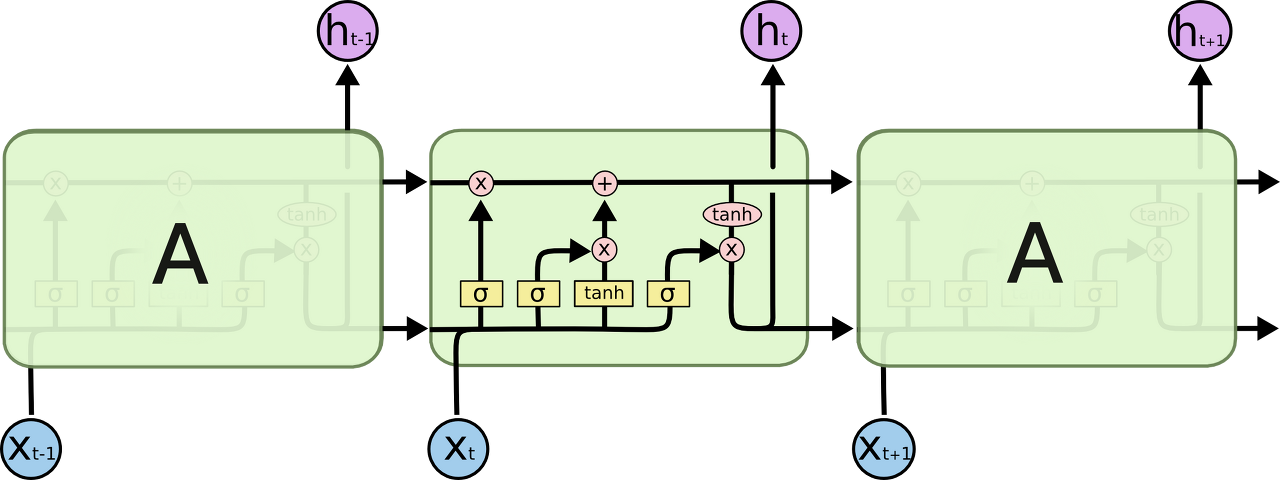

In [10]:
## Making Word2Index for one_hot_encoding

def Make_Word2Index(ctxt : list):
  word2index = dict()
  words = []
  if type(ctxt) == list:
    for text in ctxt:
      for word in text.split(" "):
        words.append(word)
  else :
    for word in ctxt.split(" "):
      words.append(word)

  word2index = {word : index for index, word in enumerate(list(set(words)))}
  return word2index

## One hot Encoding function  
def one_hot_encoding(text, word2index): # -> input = text, word2index from above function
  one_hot_encode = []

  for word in text.split(" "):
    one_hot_vector = [0]*(len(word2index))
    one_hot_vector[word2index[word]] = 1
    one_hot_encode.append(one_hot_vector)

  return one_hot_encode

In [11]:
""" Do One hot Encoding """

## ctxt Example
ctxt = [
              '신은 항상 우리가 하는 말을 듣고 있다 따라서 마음속으로 하는 혼잣말에도 주의하라',
              '가장 귀중한 사랑의 가치는 희생과 헌신이다',
              '양초는 남을 밝게 해 주며 자신을 소비한다',
              '하루에 3시간을 걸으면 7년 후에 지구를 한바퀴 돌 수 있다',
              '먼저핀꽃은 먼저진다 남보다 먼저 공을 세우려고 조급히 서둘것이 아니다'
]
## Make word2index
word2index = Make_Word2Index(ctxt)

text = ctxt[1]
## One hot Encoding
input = one_hot_encoding(text, word2index)
input = torch.Tensor([input]) ## List needs to be transformed into Tensor for calculation
print(text)
print("Size of input : ", input.size())
print("input : ", input)

가장 귀중한 사랑의 가치는 희생과 헌신이다
Size of input :  torch.Size([1, 6, 42])
input :  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [12]:
h_dim = 128  # hidden_dimension
input_size = len(word2index)  # Dimension of input meaning size of word2index
output_size = len(word2index)

## Repeat the above process using the previous hidden state and cell state for the next sequence after the corresponding process ✔

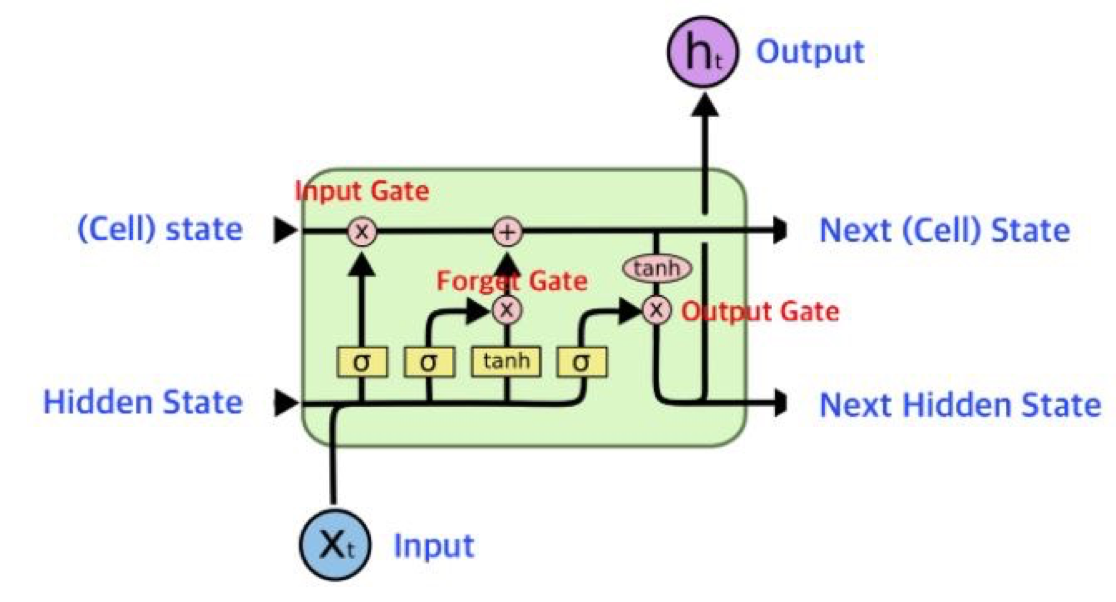

In [13]:
""" Make LSTM Cell (class) """

### Use the above process to create a class

class LSTM_Cell(nn.Module):
  def __init__(self, input_size, h_dim):
    super(LSTM_Cell, self).__init__() ### Inheritance, error if not present
    self.input_size = input_size
    self.h_dim = h_dim
    self.x2h = nn.Linear(input_size, 4 * h_dim)
    self.h2h = nn.Linear(h_dim, 4 * h_dim)

  def forward(self, x, hidden_state, cell_state):
    hx, cx = hidden_state, cell_state
    all_gate = self.x2h(x) + self.h2h(hx)
    input_gate, forget_gate, cell_gate ,output_gate = all_gate.chunk(4,dim=2)

    input_gate = torch.sigmoid(input_gate)
    forget_gate = torch.sigmoid(forget_gate)
    cell_gate = torch.tanh(cell_gate)
    output_gate = torch.sigmoid(output_gate)

    new_cell_state = torch.mul(cx, forget_gate) + torch.mul(input_gate, cell_gate)
    new_hidden_state = torch.mul(output_gate, torch.tanh(new_cell_state))    
    
    return new_cell_state, new_hidden_state

In [14]:
""" Make LSTM Cell with LSTM Cell (class) """

class LSTM(nn.Module):
  def __init__(self, input_size, h_dim, output_size):
    super(LSTM,self).__init__()
    self.input_size = input_size
    self.h_dim = h_dim
    self.output_size = output_size
    self.lstm = LSTM_Cell(input_size, h_dim)
    self.fc = nn.Linear(h_dim, output_size)
  
  def forward(self, x, hidden_state = None, cell_state = None): 
    if hidden_state is not None:
      hidden_state = hidden_state
    else:
      hidden_state = torch.zeros((x.size(0),1,self.h_dim))
    if cell_state is not None:
      cell_state = cell_state
    else:
      cell_state = torch.zeros((x.size(0),1,self.h_dim))
    
    outputs = list() ## list for sum the outputs for each sequence

    ## Use the for statement to proceed with the process for all sequence
    for seq in range(x.size(1)) :
      hidden_state, cell_state = self.lstm(x[:, seq, :].unsqueeze(1), \
                                           hidden_state, cell_state)
      outputs.append(hidden_state)

    outputs = torch.cat(outputs, dim=1)
    result = self.fc(outputs)

    return result, hidden_state, cell_state

In [15]:
lstm = LSTM(input_size,h_dim,output_size)

In [16]:
output, hidden_state, cell_state = lstm(input)
print("Size of output :\n", output.size())
print("output :\n", output)

Size of output :
 torch.Size([1, 6, 42])
output :
 tensor([[[ 0.0143, -0.0348, -0.0005, -0.0143,  0.0709, -0.0630,  0.0237,
          -0.0949,  0.0424, -0.0076, -0.0366,  0.0699, -0.0338,  0.0654,
          -0.0486, -0.0370, -0.0039,  0.0576, -0.0337, -0.0360, -0.0536,
           0.0010,  0.0582,  0.0600, -0.0134,  0.0680,  0.0066,  0.1301,
           0.0466, -0.1071, -0.0346,  0.0378,  0.0414,  0.0789,  0.0491,
           0.0456,  0.0623,  0.0605, -0.0781, -0.0996,  0.0936, -0.0089],
         [-0.0157, -0.0575, -0.0154, -0.0166,  0.0614, -0.0482,  0.0722,
          -0.0407, -0.0179, -0.0419, -0.0476,  0.0702, -0.0202, -0.0084,
          -0.0402, -0.0149, -0.0023,  0.0631, -0.0510, -0.0203, -0.0533,
          -0.0346,  0.0607,  0.0926,  0.0624,  0.1125, -0.0083,  0.1577,
           0.0629, -0.0238,  0.0029,  0.0240,  0.0848,  0.0476,  0.0162,
           0.0376,  0.0439, -0.0034, -0.1170, -0.1069,  0.1232, -0.1145],
         [-0.0447, -0.0277,  0.0259,  0.0274, -0.0032, -0.0318,  0.0657